<a href="https://colab.research.google.com/github/maglili/ai_cup-mango-cnn_base/blob/main/nn_crop_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab

- 將 baseline 的下游從 svm 轉換為 nn。
- 訓練練資料的正負資料集不平衡。
- 圖片被裁切成數個小bbox

In [ ]:
cd /content/drive/MyDrive/Projects/AI_CUP-Mango

[Errno 2] No such file or directory: '/content/drive/MyDrive/Projects/AI_CUP-Mango'
/content


In [ ]:
pwd

'/content'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing data

In [2]:
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pickle 
import matplotlib.pylab as plt # plot module

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU is avalible.')
  print('Working on:', torch.cuda.get_device_name())
else:
  device = torch.device('cpu')
  print('GPU is not avalible.')
  print('Working on CPU')

GPU is avalible.
Working on: Tesla T4


In [87]:
with open("/content/drive/MyDrive/Mango/trainpkl/train_feature.pkl", 'rb') as f:
    train_feature = pickle.load(f)

with open("/content/drive/MyDrive/Mango/devpkl/dev_feature.pkl", 'rb') as f:
    dev_feature = pickle.load(f)

In [88]:
print('len of train_feature:',len(train_feature))
print('len of dev_feature:',len(dev_feature))

len of train_feature: 25768
len of dev_feature: 3681


## Spliting 5 stacks

train data set

In [89]:
c0_pos = []
c0_neg = []
c1_pos = []
c1_neg = []
c2_pos = []
c2_neg = []
c3_pos = []
c3_neg = []
c4_pos = []
c4_neg = []

In [90]:
for img, label in train_feature:
  if label[0][0][0] == 1:
    c0_pos.append((img, 1))
  
  else:
    c0_neg.append((img, 0))
    
  if label[0][0][1] == 1:
    c1_pos.append((img, 1))
  else:
    c1_neg.append((img, 0))

    if label[0][0][2] == 1:
        c2_pos.append((img, 1))
    else:
        c2_neg.append((img, 0))
        
    if label[0][0][3] == 1:
        c3_pos.append((img, 1))
    else:
        c3_neg.append((img, 0))
        
    if label[0][0][4] == 1:
        c4_pos.append((img, 1))
    else:
        c4_neg.append((img, 0))

Dev data set

In [91]:
c0_pos_dev = []
c0_neg_dev = []
c1_pos_dev = []
c1_neg_dev = []
c2_pos_dev = []
c2_neg_dev = []
c3_pos_dev = []
c3_neg_dev = []
c4_pos_dev = []
c4_neg_dev = []

In [92]:
for img, label in dev_feature:
    if label[0][0][0] == 1:
        c0_pos_dev.append((img, 1))
    else:
        c0_neg_dev.append((img, 0))
    
    if label[0][0][1] == 1:
        c1_pos_dev.append((img, 1))
    else:
        c1_neg_dev.append((img, 0))

    if label[0][0][2] == 1:
        c2_pos_dev.append((img, 1))
    else:
        c2_neg_dev.append((img, 0))
        
    if label[0][0][3] == 1:
        c3_pos_dev.append((img, 1))
    else:
        c3_neg_dev.append((img, 0))
        
    if label[0][0][4] == 1:
        c4_pos_dev.append((img, 1))
    else:
        c4_neg_dev.append((img, 0))

In [93]:
print('Train:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos), len(c0_neg), len(c0_pos)+len(c0_neg)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos), len(c1_neg), len(c1_pos)+len(c1_neg)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos), len(c2_neg), len(c2_pos)+len(c2_neg)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos), len(c3_neg), len(c3_pos)+len(c3_neg)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos), len(c4_neg), len(c4_pos)+len(c4_neg)))
print()

print('Dev:')
print('c0: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c0_pos_dev), len(c0_neg_dev), len(c0_pos_dev)+len(c0_neg_dev)))
print('c1: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c1_pos_dev), len(c1_neg_dev), len(c1_pos_dev)+len(c1_neg_dev)))
print('c2: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c2_pos_dev), len(c2_neg_dev), len(c2_pos_dev)+len(c2_neg_dev)))
print('c3: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c3_pos_dev), len(c3_neg_dev), len(c3_pos_dev)+len(c3_neg_dev)))
print('c4: pos= {:<5}  neg= {:<5}  sum= {:<5}'.format(len(c4_pos_dev), len(c4_neg_dev), len(c4_pos_dev)+len(c4_neg_dev)))

Train:
c0: pos= 2122   neg= 23646  sum= 25768
c1: pos= 419    neg= 25349  sum= 25768
c2: pos= 11349  neg= 14000  sum= 25349
c3: pos= 14441  neg= 10908  sum= 25349
c4: pos= 904    neg= 24445  sum= 25349

Dev:
c0: pos= 308    neg= 3373   sum= 3681 
c1: pos= 60     neg= 3621   sum= 3681 
c2: pos= 1765   neg= 1916   sum= 3681 
c3: pos= 1938   neg= 1743   sum= 3681 
c4: pos= 170    neg= 3511   sum= 3681 


## Combining pos and net data

In [94]:
def data_list(pos_list, neg_list):
    """
    把正負資料合併並打散後，輸出資料
    """
    pos = pos_list
    neg = neg_list
    output = pos + neg        
    output = shuffle(output, random_state=0)
    return output

In [95]:
c0 = data_list(c0_pos, c0_neg)
c1 = data_list(c1_pos, c1_neg)
c2 = data_list(c2_pos, c2_neg)
c3 = data_list(c3_pos, c3_neg)
c4 = data_list(c4_pos, c4_neg)

c0_dev = data_list(c0_pos_dev, c0_neg_dev)
c1_dev = data_list(c1_pos_dev, c1_neg_dev)
c2_dev = data_list(c2_pos_dev, c2_neg_dev)
c3_dev = data_list(c3_pos_dev, c3_neg_dev)
c4_dev = data_list(c4_pos_dev, c4_neg_dev)

## Check label balance

In [96]:
def check_balance(data):
    """
    檢查資料數量是否一致
    """
    pos=0
    neg=0
    for i,j in data:
        if j == 1:
            pos += 1
        else:
            neg += 1
    print('pos:',pos)
    print('neg:',neg)
    print('sum:',pos+neg)

In [97]:
print('Train:')
print()
for i in [c0, c1, c2, c3, c4]:
    check_balance(i)
    print('-'*10)

Train:

pos: 2122
neg: 23646
sum: 25768
----------
pos: 419
neg: 25349
sum: 25768
----------
pos: 11349
neg: 14000
sum: 25349
----------
pos: 14441
neg: 10908
sum: 25349
----------
pos: 904
neg: 24445
sum: 25349
----------


In [98]:
print('Dev:')
print()
for i in [c0_dev, c1_dev, c2_dev, c3_dev, c4_dev]:
    check_balance(i)
    print('-'*10)

Dev:

pos: 308
neg: 3373
sum: 3681
----------
pos: 60
neg: 3621
sum: 3681
----------
pos: 1765
neg: 1916
sum: 3681
----------
pos: 1938
neg: 1743
sum: 3681
----------
pos: 170
neg: 3511
sum: 3681
----------


## Splitting features and labels

In [99]:
def split_x_y(data):
    """
    把資料中的 feature 跟 label 分離
    """
    X=[]
    y=[]
    for i,j in data:
        X.append(i)
        y.append(j)
    return X,y

In [100]:
c0_X, c0_y = split_x_y(c0)
c1_X, c1_y = split_x_y(c1)
c2_X, c2_y = split_x_y(c2)
c3_X, c3_y = split_x_y(c3)
c4_X, c4_y = split_x_y(c4)

In [101]:
c0_X_dev, c0_y_dev = split_x_y(c0_dev)
c1_X_dev, c1_y_dev = split_x_y(c1_dev)
c2_X_dev, c2_y_dev = split_x_y(c2_dev)
c3_X_dev, c3_y_dev = split_x_y(c3_dev)
c4_X_dev, c4_y_dev = split_x_y(c4_dev)

## Function for calc metrics

In [102]:
def calc_metrics(train=True):
    if train:
        (TP, FP, TN, FN) = useful_stuff['train_metric'][-1]
        print('[Train]Total sample: {}'.format(TP+FP+TN+FN))
    else:
        (TP, FP, TN, FN) = useful_stuff['valid_metric'][-1]
        print('[Dev]Total sample: {}'.format(TP+FP+TN+FN))

    acc = (TP + TN) / (TP + FP + TN + FN)

    recall = TP / (TP + FN) #召回率是在所有正樣本當中，能夠預測多少正樣本的比例
    specificity = TN / (TN + FP) #特異度是在所有負樣本當中，能夠預測多少負樣本的比例

    precision = TP / (TP + FP) #準確率為在所有預測為正樣本中，有多少為正樣本

    f1 = (2 * recall * precision ) / (recall + precision) #F1-score則是兩者的調和平均數
    mcc = ( TP*TN - FP*FN ) / np.sqrt( ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) )

    print('TP:',TP)
    print('FP:',FP)
    print('TN:',TN)
    print('FN:',FN)
    print()
    print('acc:', acc)
    print('recall:', recall)
    print('specificity:', specificity)
    print('precision:', precision)
    print('f1:',f1)
    print('mcc:',mcc)

# class 0

## dataset

In [103]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [104]:
train_set_c0 = Data(c0_X, c0_y)
dev_set_c0 = Data(c0_X_dev, c0_y_dev)

## model

### Prepare

In [105]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [106]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=1, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer *`parameters`*

In [109]:
model_c0 = Net(neuron=1, p=0.2)
model_c0.to(device);

N_train = len(train_set_c0)
N_test = len(dev_set_c0)

weights = [1.18, 15.82]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c0.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c0, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c0, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1) # learning rate decay

## training

In [110]:
useful_stuff = train(model=model_c0, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=150)

In [113]:
torch.save(model_c0, '/content/drive/MyDrive/Mango/nn/model_Tc00.pt')

## Learning Curve

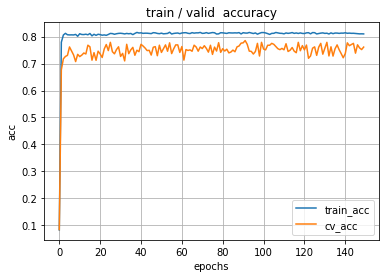

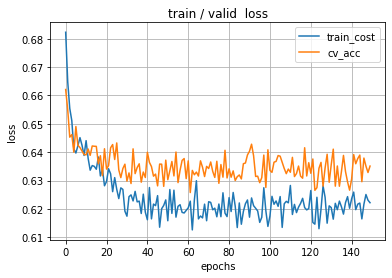

In [111]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [112]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 25768
TP: 998
FP: 3768
TN: 19878
FN: 1124

acc: 0.8101521266687364
recall: 0.470311027332705
specificity: 0.8406495813245369
precision: 0.20939991607217792
f1: 0.2897793263646922
mcc: 0.22016565113549708
--------------------

[Dev]Total sample: 3681
TP: 164
FP: 735
TN: 2638
FN: 144

acc: 0.7612061939690301
recall: 0.5324675324675324
specificity: 0.7820930922027869
precision: 0.18242491657397109
f1: 0.27174813587406793
mcc: 0.202735348872751


# class 1

## dataset

In [114]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [115]:
train_set_c1 = Data(c1_X, c1_y)
dev_set_c1 = Data(c1_X_dev, c1_y_dev)

## model

### Prepare

In [116]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [118]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=1, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [119]:
model_c1 = Net(neuron=1, p=0.2)
model_c1.to(device);

N_train = len(train_set_c1)
N_test = len(dev_set_c1)

weights = [1.18, 85.39]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c1.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c1, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c1, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [120]:
useful_stuff = train(model=model_c1, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=150)

In [126]:
torch.save(model_c1, '/content/drive/MyDrive/Mango/nn/model_Tc1.pt')

## Learning Curve

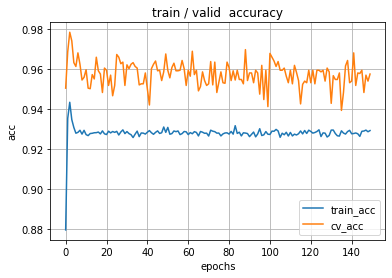

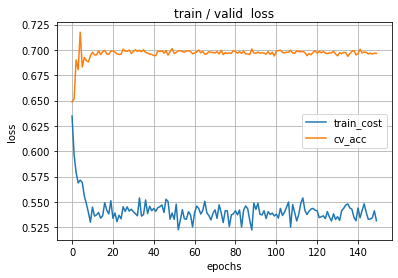

In [121]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [124]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 25768
TP: 164
FP: 1566
TN: 23783
FN: 255

acc: 0.929330953120149
recall: 0.3914081145584726
specificity: 0.9382224150854077
precision: 0.09479768786127167
f1: 0.15262912982782686
mcc: 0.16658758735853713
--------------------

[Dev]Total sample: 3681


ZeroDivisionError: ignored

# class 2

In [127]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [128]:
train_set_c2 = Data(c2_X, c2_y)
dev_set_c2 = Data(c2_X_dev, c2_y_dev)

## model

### Prepare

In [129]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [130]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=1, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [131]:
model_c2 = Net(neuron=1, p=0.2)
model_c2.to(device);

N_train = len(train_set_c2)
N_test = len(dev_set_c2)

weights = [1.087, 1.0]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c2.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c2, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c2, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [132]:
useful_stuff = train(model=model_c2, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=150)

In [133]:
torch.save(model_c2, '/content/drive/MyDrive/Mango/nn/model_Tc2.pt')

## Learning Curve

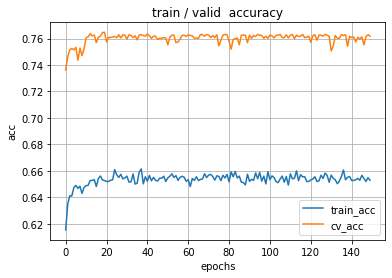

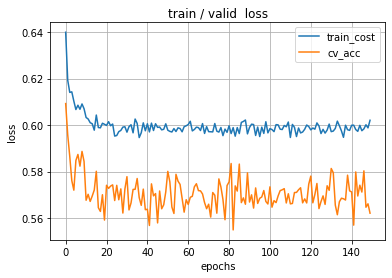

In [134]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [135]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 25349
TP: 9338
FP: 6789
TN: 7211
FN: 2011

acc: 0.6528462661248965
recall: 0.8228037712573795
specificity: 0.5150714285714286
precision: 0.5790289576486637
f1: 0.6797204833309068
mcc: 0.3492285811414865
--------------------

[Dev]Total sample: 3681
TP: 1323
FP: 435
TN: 1481
FN: 442

acc: 0.7617495245857104
recall: 0.7495750708215297
specificity: 0.7729645093945721
precision: 0.7525597269624573
f1: 0.7510644337212602
mcc: 0.5226250496154816


# class 3

## dataset

In [136]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [137]:
train_set_c3 = Data(c3_X, c3_y)
dev_set_c3 = Data(c3_X_dev, c3_y_dev)

## model

### Prepare

In [138]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [139]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=1, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [146]:
model_c3 = Net(neuron=1, p=0.2)
model_c3.to(device);

N_train = len(train_set_c3)
N_test = len(dev_set_c3)

weights = [0.8, 1.882]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c3.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c3, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c3, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [147]:
useful_stuff = train(model=model_c3, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=150)

In [148]:
torch.save(model_c3, '/content/drive/MyDrive/Mango/nn/model_Tc3.pt')

## Learning Curve

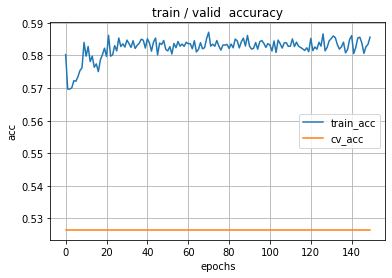

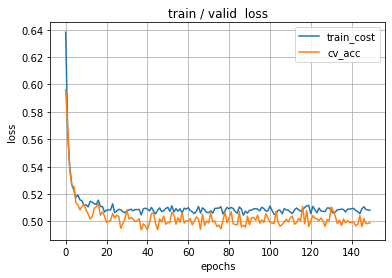

In [149]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [150]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 25349
TP: 14254
FP: 10317
TN: 591
FN: 187

acc: 0.5856246794745354
recall: 0.9870507582577384
specificity: 0.05418041804180418
precision: 0.580114769443653
f1: 0.730749512970368
mcc: 0.11835747985341417
--------------------

[Dev]Total sample: 3681
TP: 1938
FP: 1743
TN: 0
FN: 0

acc: 0.5264873675631622
recall: 1.0
specificity: 0.0
precision: 0.5264873675631622
f1: 0.6898024559530166
mcc: nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


# class 4

## dataset

In [151]:
class Data(Dataset):
    def __init__(self, x_list, y_list):
        self.x_list = x_list
        self.y_list = y_list
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_list[idx][0])
        y = torch.tensor(self.y_list[idx])

        return x, y

    def __len__(self):
        return len(self.x_list)

In [152]:
train_set_c4 = Data(c4_X, c4_y)
dev_set_c4 = Data(c4_X_dev, c4_y_dev)

## model

### Prepare

In [153]:
 def train(model, train_loader, cv_loader, optimizer, N_train, N_test, epochs=20):
 
    useful_stuff = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[], 'train_metric':[], 'valid_metric':[]} 

    for epoch in tqdm(range(epochs)):
        #training===========================================
        model.train() # Switch to train mode
        correct = 0
        training_loss=[]
        TP = FP = TN = FN = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            training_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y == 1)).sum().item()
            FP += ((yhat == 1) & (y == 0)).sum().item()
            TN += ((yhat == 0) & (y == 0)).sum().item()
            FN += ((yhat == 0) & (y == 1)).sum().item()       

        useful_stuff['train_cost'].append(np.mean(training_loss))
        useful_stuff['train_acc'].append(correct / N_train)
        useful_stuff['train_metric'].append((TP, FP, TN, FN))

        #print('[epoch {}]'.format(epoch))
        #print('train_acc:',correct / N_train)
        #print('train_loss:',np.mean(training_loss))
        #print()

        #valid==================================================
        model.eval() # Switch to train mode
        correct = 0
        cv_loss=[]
        TP = FP = TN = FN = 0

        with torch.no_grad():
          for x_test, y_test in cv_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
            loss = criterion(z, y_test)         
            cv_loss.append(loss.data.item())

            # calu metric
            TP += ((yhat == 1) & (y_test == 1)).sum().item()
            FP += ((yhat == 1) & (y_test == 0)).sum().item()
            TN += ((yhat == 0) & (y_test == 0)).sum().item()
            FN += ((yhat == 0) & (y_test == 1)).sum().item() 

          useful_stuff['valid_cost'].append(np.mean(cv_loss))
          useful_stuff['valid_acc'].append(correct / N_test)
          useful_stuff['valid_metric'].append((TP, FP, TN, FN))

        #print('train_acc:',correct / N_test)
        #print('train_loss:',np.mean(np.mean(cv_loss)))
        #print('='*10)

        scheduler.step(np.mean(cv_loss)) # learning rate scheduler <---------------------------------------------------------

    return useful_stuff

In [154]:
class Net(nn.Module):   
    # Constructor
    def __init__(self,neuron=1, p=0.1):
        super(Net, self).__init__()
        self.neuron=neuron
        self.drop=p

        self.step = nn.Sequential(
            nn.Linear(2000, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, self.neuron),
            nn.BatchNorm1d(self.neuron),
            nn.ReLU(),
            nn.Dropout(self.drop),

            nn.Linear(self.neuron, 2),           
        )
    def forward(self, x):
        x = self.step(x)
        return x

### Hpyer parameters

In [160]:
model_c4 = Net(neuron=1, p=0.2)
model_c4.to(device);

N_train = len(train_set_c4)
N_test = len(dev_set_c4)

weights = [0.95, 25.17]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

learning_rate = 0.0005
optimizer = torch.optim.AdamW(model_c4.parameters(), lr=learning_rate, amsgrad=True)

train_loader = DataLoader(train_set_c4, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_set_c4, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.1) # learning rate decay

## training

In [161]:
useful_stuff = train(model=model_c4, train_loader=train_loader, cv_loader=dev_loader, N_train=N_train, N_test=N_test, optimizer=optimizer, epochs=150)

In [162]:
torch.save(model_c4, '/content/drive/MyDrive/Mango/nn/model_Tc4.pt')

## Learning Curve

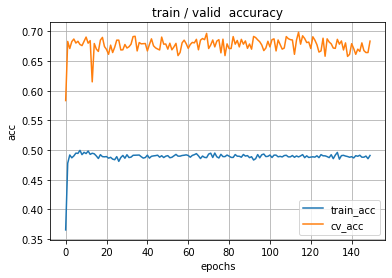

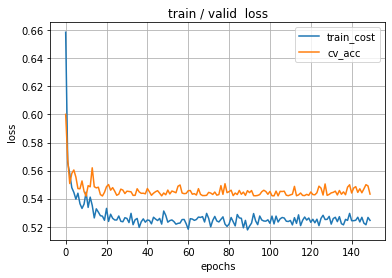

In [163]:
plt.plot(useful_stuff['train_acc'], label='train_acc')
plt.plot(useful_stuff['valid_acc'], label='cv_acc')
plt.title('train / valid  accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
#axes = plt.gca()
#axes.set_ylim([0.4, 1])
plt.legend()
plt.grid()
plt.show()

plt.plot(useful_stuff['train_cost'], label='train_cost')
plt.plot(useful_stuff['valid_cost'], label='cv_acc')
plt.title('train / valid  loss')
plt.xlabel('epochs')
plt.ylabel('loss')
#axes = plt.gca()
#axes.set_ylim([0, 1])
plt.legend()
plt.grid()
plt.show()

In [164]:
calc_metrics()
print('-'*20)
print()
calc_metrics(False)

[Train]Total sample: 25349
TP: 853
FP: 12853
TN: 11592
FN: 51

acc: 0.49094638841768906
recall: 0.9435840707964602
specificity: 0.47420740437717324
precision: 0.062235517291697066
f1: 0.11676933607118413
mcc: 0.15547157483816143
--------------------

[Dev]Total sample: 3681
TP: 157
FP: 1151
TN: 2360
FN: 13

acc: 0.6837815810920945
recall: 0.9235294117647059
specificity: 0.6721731700370265
precision: 0.12003058103975535
f1: 0.2124492557510149
mcc: 0.26122613010140805


# Saving model

In [ ]:
torch.save(model_c0, './C2_TrainDev/model/nn-crop-imbalance/model_c0.pt')
torch.save(model_c1, './C2_TrainDev/model/nn-crop-imbalance/model_c1.pt')
torch.save(model_c2, './C2_TrainDev/model/nn-crop-imbalance/model_c2.pt')
torch.save(model_c3, './C2_TrainDev/model/nn-crop-imbalance/model_c3.pt')
torch.save(model_c4, './C2_TrainDev/model/nn-crop-imbalance/model_c4.pt')